# Seminar Software Composition - Assessing Source Code Comments Quality

In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ludo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
DATASET_FILE = 'data/pharo/class_comments_pharo.csv'

dataset = pd.read_csv(DATASET_FILE, header=None, names=['class', 'comment'])

dataset[:10]

,class,comment
0,AColorSelectorMorph,ColorComponentSelector showing an alpha gradie...
1,ASTCache,I am a simple cache for AST nodes correspondin...
2,ASTCacheReset,Announcement signaled to tell that the default...
3,ASTCacheResetTest,NaN
4,ASTEvaluationTest,I am testing AST evaluation
5,ASTPluginMeaningOfLife,A simple example for a AST transforming compil...
6,ASTTransformExamplePluginActive,This class changes the default compiler used t...
7,ASTTransformationPluginTest,NaN
8,ATraitedClass,Simple class to be traited in the tests
9,Abort,Notify to abort a task


## Dataset preparation

### Replace the NaN in the comments with empty string (IE empty comments)

In [3]:
df = dataset.copy()

df["comment"].fillna(" ", inplace=True)

print(f"Any null values left : {df.isnull().values.any()}")

Any null values left : False


## Comment length

### Preprocessing

In [4]:
nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ludo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def preprocess_comment(comment, stopwords):
    # split the comment text into lowercase words
    comment = nltk.word_tokenize(comment)        
    comment = [word.lower() for word in comment if word.isalnum()]
    

    # filter the stopwords and the punctuation
    try:
        comment = [word for word in comment if word not in stopwords]
    except:
        print(e)
    
    return comment

comments = df["comment"]
comments = [preprocess_comment(comment, stopwords=stopwords) for comment in comments]

### Computations

In [6]:
def print_comment_length_metrics(comments):
    MIN_COMMENT_LENGTH = 3

    n_empty_comments = sum(map(lambda comment: 1 if len(comment) == 0 else 0, comments))
    n_lower_length = sum(map(lambda comment: 1 if len(comment) < MIN_COMMENT_LENGTH and len(comment) > 0 else 0, comments))

    print(f"Total number of comments : {len(comments)}\n")
    print(f"Number of empty comments : {n_empty_comments}")
    print(f"Ratio of empty comments : {(n_empty_comments / len(comments))*100:.1f} %\n")

    print(f"Number of comments with too few words (but not empty) : {n_lower_length}")
    print(f"Ratio of comments too short : {(n_lower_length / len(comments))*100:.1f} %")
    

print_comment_length_metrics(comments)

Total number of comments : 7863

Number of empty comments : 1541
Ratio of empty comments : 19.6 %

Number of comments with too few words (but not empty) : 196
Ratio of comments too short : 2.5 %


### Plots

In [7]:
import matplotlib.pyplot as plt
from statistics import mean, median

def plot_histogram(values, bins, title, xlabel, ylabel, yscale_val='linear', title_additional_info="",
                   plot_average=False, plot_median=False):
    
    if title_additional_info != "":
        title = f"{title} ({title_additional_info})"
    
    plt.hist(values, bins=bins)
    plt.yscale(value=yscale_val)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if(plot_average):
        mean_val = mean(values)
        plt.axvline(mean_val, color='k', linestyle='dashed', linewidth=1)
        plt.min_ylim, max_ylim = plt.ylim()
        plt.text(mean_val*1.1, max_ylim*0.7, f"Avg : {mean_val:.2f}")
    if(plot_median):
        median_val = median(values)
        plt.axvline(median_val, color='k', linestyle='dashed', linewidth=1)
        plt.min_ylim, max_ylim = plt.ylim()
        plt.text(median_val*1.1, max_ylim*0.7, f"Median : {median_val:.2f}")
        
    plt.show()

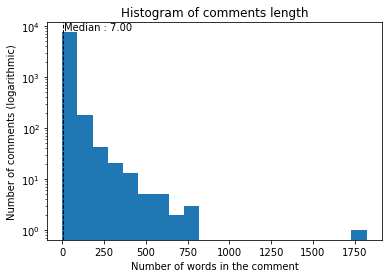

In [8]:
def plot_hist_comments_len(comments, title_additional_info = ""):
    comments_len = list(map(lambda c: len(c), comments))       
    plot_histogram(comments_len, bins=20, yscale_val='log', 
                    title="Histogram of comments length", title_additional_info=title_additional_info,
                    ylabel='Number of comments (logarithmic)', xlabel='Number of words in the comment', 
                    plot_average=False, plot_median=True)
    
plot_hist_comments_len(comments)

## Analyzing language properties of comments

In [9]:
from readcalc import readcalc
from IPython.utils import io

def get_gunning_fog(comment):
    with io.capture_output() as captured:
        calc = readcalc.ReadCalc(comment)
        val = calc.get_gunning_fog_index()
    return val 

def get_flesch_reading(comment):
    with io.capture_output() as captured:
        calc = readcalc.ReadCalc(comment)
        val = calc.get_flesch_reading_ease()
    return val 

def get_smog_index(comment):
    with io.capture_output() as captured:
        calc = readcalc.ReadCalc(comment)
        val = calc.get_smog_index()
    return val 


indices_functions = {
    'flesch_reading_ease':get_flesch_reading,
    'gunning_fog':get_gunning_fog,
    'smog_index':get_smog_index,
}

def compute_reading_ease_metrics(comments):
    # init the dictionnary that will contain each index metric as key and the values for each comment as the values
    indices_values = {}
    for index_label in indices_functions.keys():
        indices_values[index_label] = []

    for comment in tqdm(comments):
        for index_label, index_func in indices_functions.items():
            val = index_func(comment)
            indices_values[index_label].append(val)
            
    return indices_values

indices_values = compute_reading_ease_metrics(df["comment"])

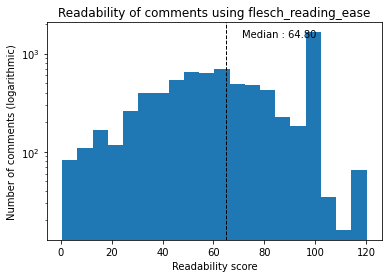

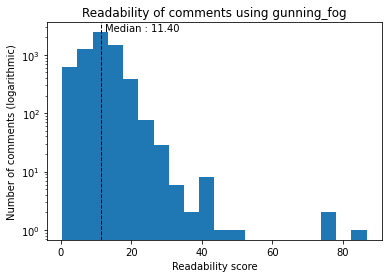

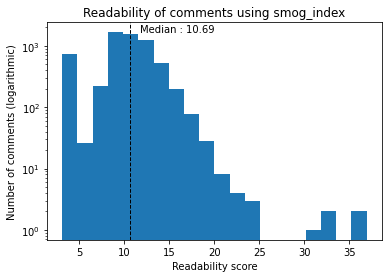

In [10]:
def plot_indices_values(indices_values, title_additional_info=""):
    for label, values in indices_values.items():
        values = list(filter(lambda val: val > 0, values))
        plot_histogram(values, bins=20, 
                        title=f"Readability of comments using {label}", title_additional_info=title_additional_info, 
                        yscale_val='log', 
                        ylabel='Number of comments (logarithmic)',
                        xlabel='Readability score',
                        plot_median=True)    



plot_indices_values(indices_values)

### Indices explained

#### Flesch reading ease

Higher is better.

[Source](https://yoast.com/flesch-reading-ease-score)
- 90-100	very easy to read, easily understood by an average 11-year-old student-
- 80-90	easy to read
- 70-80	fairly easy to read
- 60-70	easily understood by 13- to 15-year-old students
- 50-60	fairly difficult to read
- 30-50	difficult to read, best understood by college graduates
- 0-30	very difficult to read, best understood by university graduates

#### Gunning Fog

Lower is better.

[Source](https://en.wikipedia.org/wiki/Gunning_fog_index)
- 17	College graduate
- 16	College senior
- 15	College junior
- 14	College sophomore
- 13	College freshman
- 12	High school senior
- 11	High school junior
- 10	High school sophomore
- 9	High school freshman
- 8	Eighth grade
- 7	Seventh grade
- 6	Sixth grade

#### Smog index

[https://en.wikipedia.org/wiki/SMOG]
$grade = 1.043 \sqrt{number \; of \; polysyllables* \frac{30}{number\; of \;sentences}} + 3.1291$

Results can be interpreted using this [table](https://www.textcompare.org/readability/smog-index#Grade-Conversion)

#### Split the class into subwords

In [11]:
import re

def camel_case_splitter(word):
    splitted = re.sub('([A-Z][a-z]+)', r' \1', re.sub('(([A-Z]|[0-9A-Z])+)', r' \1', word)).split()
    return splitted

for class_name in df['class'][:10]:
    print(camel_case_splitter(class_name))

['A', 'Color', 'Selector', 'Morph']
['AST', 'Cache']
['AST', 'Cache', 'Reset']
['AST', 'Cache', 'Reset', 'Test']
['AST', 'Evaluation', 'Test']
['AST', 'Plugin', 'Meaning', 'Of', 'Life']
['AST', 'Transform', 'Example', 'Plugin', 'Active']
['AST', 'Transformation', 'Plugin', 'Test']
['A', 'Traited', 'Class']
['Abort']


### Code-Comment coherence

#### C_Coeff explanation

The comparison counts how many words from one set
correspond to a similar word in the other set. Two words are
similar iff their Levenshtein distance is **smaller than 2**. 

The $c_{coeff}$ metric denotes the number of corresponding words
divided by the total number of comment words. 

Based on preliminary experiments with manual evaluation,
we set two thresholds and inspect member comments with
**$c_{coeff} = 0$ and $c_{coeff} > 0.5$**.

*Quality Analysis of Source Code Comments*

In [12]:
from nltk.metrics import edit_distance

# if the edit distance is smaller than this threshold, words are considered similar
DIST_SIMILARITY_THRESHOLD = 2

stopwords = nltk.corpus.stopwords.words('english')

def compute_c_coeff(comments, class_names, class_names_splitter=camel_case_splitter, stopwords=[]): 
    class_coeff_dict= {}

    for comment, class_name in tqdm(zip(comments, class_names)):
        # split class name into tokens by camel case and set them to lower case
        splitted_class_name = class_names_splitter(class_name)
        splitted_class_name = [word.lower() for word in splitted_class_name]

        # tokenize, remove stop words and split commment into words
        comment = preprocess_comment(comment, stopwords=stopwords)

        # if this is an empty comment, skip this comment computation and set to -1
        # TODO : discard
        if len(comment) == 0:
            class_coeff_dict[class_name] = -1
            continue

        n_similar = 0
        for comment_word in comment:
            for class_word in splitted_class_name:
                if edit_distance(comment_word, class_word) < DIST_SIMILARITY_THRESHOLD:
                    n_similar += 1
                    break

        c_coeff = n_similar / (float)(len(comment))
        class_coeff_dict[class_name] = c_coeff
    
    return class_coeff_dict


class_coeff_dict = compute_c_coeff(df["comment"], df["class"], class_names_splitter=camel_case_splitter, stopwords=stopwords)

### Sample some examples

In [13]:
N_SAMPLE = 5

for iter_tuple in df.sample(n=N_SAMPLE).itertuples():
    class_name = iter_tuple[1]
    comment = iter_tuple[2]
    print(f"[Class] {class_name} : {comment[:50]}...\", c_coeff = {class_coeff_dict[class_name]:.2f}\n")

[Class] KMComposedModifier : I represent a composed key modifier. I contain a c...", c_coeff = 0.21

[Class] Shape : I am an abstract class that knows my bounds and if...", c_coeff = 0.00

I work at the p...", c_coeff = 0.10

See class side....", c_coeff = 0.20

[Class] JoinSide : The join side...", c_coeff = 1.00



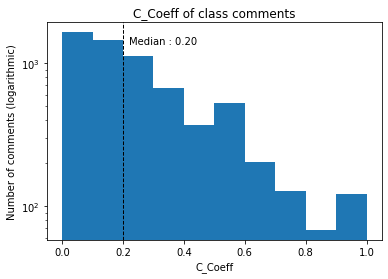

In [14]:
def plot_c_coeffs(class_coeff_dict, title_additional_info=""):
    values = list(filter(lambda val: val >= 0, class_coeff_dict.values()))
    plot_histogram(values, bins=10, 
                        title=f"C_Coeff of class comments", title_additional_info=title_additional_info,
                        yscale_val='log', 
                        ylabel='Number of comments (logarithmic)',
                        xlabel='C_Coeff',
                        plot_median=True)
    
plot_c_coeffs(class_coeff_dict)

In [15]:
from functools import reduce

THRESH_USELESS_HIGH = 0.75
THRESH_USELESS_LOW = 0.5

def print_c_coeffs_metrics(class_coeff_dict, thresh_high, thresh_low):
    c_coeff_vals = class_coeff_dict.values()
    
    n_non_empty = reduce(lambda n, val: n + 1 if val >= 0 else n, c_coeff_vals, 0)
    
    
    n_zero = reduce(lambda n, val: n + 1 if val == 0 else n, c_coeff_vals, 0)
    n_low = reduce(lambda n, val: n + 1 if val >= thresh_low else n, c_coeff_vals, 0)
    n_high = reduce(lambda n, val: n + 1 if val >= thresh_high else n, c_coeff_vals, 0)

    
    print(f"Number of non-empty comments : {n_non_empty}\n")
    print(f"Number of comments with c_coeff = 0 (completely dissimilar) : {n_zero} ({n_zero*100/n_non_empty:.2f}) %")
    print(f"Number of comments with c_coeff >= {thresh_low} (quite similar) : {n_low} ({n_low*100/n_non_empty:.2f}) %")
    print(f"Number of comments with c_coeff >= {thresh_high} (really similar) : {n_high} ({n_high*100/n_non_empty:.2f}) %")
    
print_c_coeffs_metrics(class_coeff_dict, thresh_high=THRESH_USELESS_HIGH, thresh_low=THRESH_USELESS_LOW)

Number of non-empty comments : 6322

Number of comments with c_coeff = 0 (completely dissimilar) : 664 (10.50) %
Number of comments with c_coeff >= 0.5 (quite similar) : 1051 (16.62) %
Number of comments with c_coeff >= 0.75 (really similar) : 312 (4.94) %


## Python comments

In [16]:
import os
DATA_PATH = 'data/python/'

In [17]:
python_datasets_dict = {}

for filename in os.listdir(DATA_PATH):
    df = pd.read_csv(f"{DATA_PATH}{filename}")
    df["classComment"].fillna("", inplace=True)
    # find the dot at the end and slice to remove the extension
    dataset_label = filename[:filename.rfind('.')]
    python_datasets_dict[dataset_label] = df


s = python_datasets_dict['django']["classComment"]
c_length = s.str.len().values.tolist()

c_length = filter(lambda x: x < 3 and x != 0, c_length)

print(list(c_length))

### Comments length

For dataset of comments from : django
-----------------------------------------------------
Total number of comments : 8750

Number of empty comments : 7587
Ratio of empty comments : 86.7 %

Number of comments with too few words (but not empty) : 0
Ratio of comments too short : 0.0 %


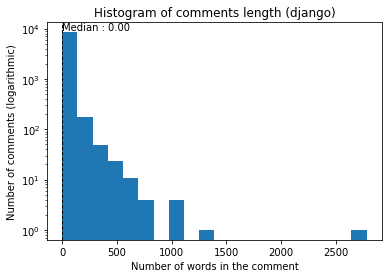

For dataset of comments from : ipython
-----------------------------------------------------
Total number of comments : 543

Number of empty comments : 327
Ratio of empty comments : 60.2 %

Number of comments with too few words (but not empty) : 0
Ratio of comments too short : 0.0 %


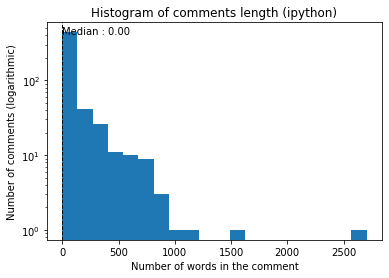

For dataset of comments from : mailpile
-----------------------------------------------------
Total number of comments : 521

Number of empty comments : 239
Ratio of empty comments : 45.9 %

Number of comments with too few words (but not empty) : 0
Ratio of comments too short : 0.0 %


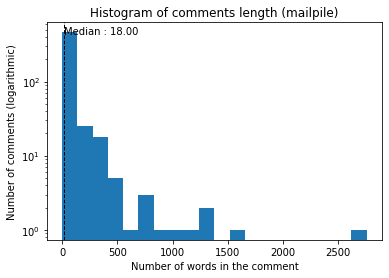

For dataset of comments from : pandas
-----------------------------------------------------
Total number of comments : 1753

Number of empty comments : 1375
Ratio of empty comments : 78.4 %

Number of comments with too few words (but not empty) : 0
Ratio of comments too short : 0.0 %


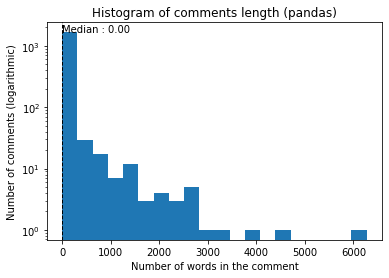

For dataset of comments from : pipenv
-----------------------------------------------------
Total number of comments : 1866

Number of empty comments : 703
Ratio of empty comments : 37.7 %

Number of comments with too few words (but not empty) : 0
Ratio of comments too short : 0.0 %


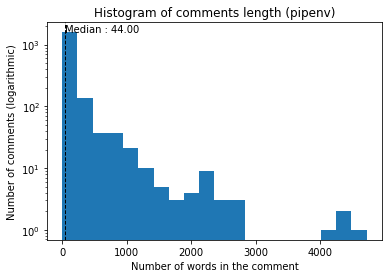

For dataset of comments from : pytorch
-----------------------------------------------------
Total number of comments : 2699

Number of empty comments : 2179
Ratio of empty comments : 80.7 %

Number of comments with too few words (but not empty) : 0
Ratio of comments too short : 0.0 %


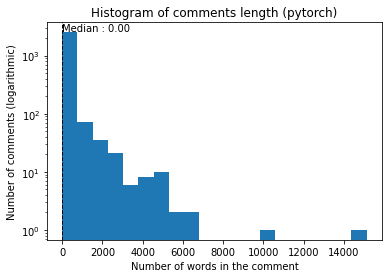

For dataset of comments from : requests
-----------------------------------------------------
Total number of comments : 79

Number of empty comments : 36
Ratio of empty comments : 45.6 %

Number of comments with too few words (but not empty) : 0
Ratio of comments too short : 0.0 %


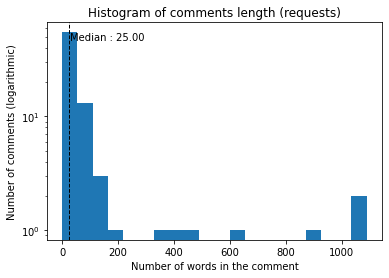

In [18]:
for label in python_datasets_dict.keys():
    df = python_datasets_dict[label].copy()
    print(f"For dataset of comments from : {label}")
    print("-----------------------------------------------------")
    print_comment_length_metrics(df["classComment"])
    plot_hist_comments_len(df["classComment"], title_additional_info=label)
    

### Readability indices

In [19]:
## TODO : transform pipeline and / or save results somewhere
for label in python_datasets_dict.keys():
    df = python_datasets_dict[label].copy()
    indices_values = compute_reading_ease_metrics(comments)
    #plot_indices_values(indices_values=indices_values, title_additional_info=label)
    
    

In [20]:
for label in python_datasets_dict.keys():
    df = python_datasets_dict[label].copy()
    
    class_coeff_dict = compute_c_coeff(df["classComment"], df["className"], 
                                       class_names_splitter=camel_case_splitter, stopwords=stopwords)
    
    print_comment_length_metrics

TypeError: expected string or bytes-like object